In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.options.display.float_format = '{:,}'.format

In [2]:
df = pd.read_csv('../dataset/rumah123_jabodetabek.csv')

In [3]:
df.sample(5, random_state=16) # initial dataset

,location,sub_district,title,price,lt,lb
10101,jakarta-utara,tanjung-priok,Dijual Kontrakan 10 Pintu Bebas Banjir Daerah ...,"Rp 1,9 Miliar",194 m²,350 m²
32194,jakarta-barat,kalideres,RUMAH MINIMALIS 2 LANTAI FULL SIAP HUNI DI CIT...,"Rp 1,9 Miliar",90 m²,144 m²
37218,bogor,ciawi,Rumah View Gunung Pancar Kawasan Taman Wisata ...,Rp 950 Juta,72 m²,45 m²
63727,tangerang,larangan,Rumah Baru Siap Huni Model Elegant Larangan Ta...,"Rp 2,85 Miliar",280 m²,304 m²
40244,bogor,cisarua,Dijual Rumah Dengan Pemandangan Gunung Di Cisa...,"Rp 14,9 Miliar",8430 m²,1565 m²


## Cleaning

### Remove Duplicate Values

In [4]:
df = df.drop_duplicates()

### Remove Rows with Null Values

In [5]:
df.isna().sum()

location          0
sub_district      0
title             3
price             0
lt               55
lb              390
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.isna().sum()

location        0
sub_district    0
title           0
price           0
lt              0
lb              0
dtype: int64

### Change Location and Sub District Formatting

#### Replace '-' with blank space (' ')

In [8]:
df['sub_district'] = df['sub_district'].str.replace('-', ' ')
df['location'] = df['location'].str.replace('-', ' ')

#### Capitalize Each Word

In [9]:
df['sub_district'] = df['sub_district'].str.title()
df['location'] = df['location'].str.title()

### Convert price from 'rupiah terbilang' to float

In [10]:
df['price_wording'] = df['price']

df['price'] = df['price'].str.replace('Rp ', '')
df['price'] = df['price'].str.replace('Hubungi', '')
df['price'] = df['price'].str.replace(',', '.')

df[['price', 'price_unit']] = df['price'].str.split(' ', expand=True)
df = df[df['price_unit'] != 'Agen']

In [11]:
df['price'] = df['price'].astype(float)

def multiply_price(row: float):
    if row['price_unit'] == 'Miliar':
        return row['price'] * 1_000_000_000
    elif row['price_unit'] == 'Juta':
        return row['price'] * 1_000_000
    else:
        return row['price']

df['price'] = df.apply(multiply_price, axis=1)

df = df.drop(columns=['price_unit'])

### Remove square root (m²) unit

In [12]:
df['lt'] = df['lt'].str.replace(' m²', '')
df['lb'] = df['lb'].str.replace(' m²', '')

df['lt'] = df['lt'].astype(float)
df['lb'] = df['lb'].astype(float)


### Filter Based on Domain Knowledge

#### Filter Only Values that LT and LB < 5000 meter squared

In [13]:
df = df[(df['lt'] < 5_000) & (df['lb'] < 5_000)]

#### Remove Rumah dengan Keyword Sewa

In [14]:
contain_sewa = df[df['title'].str.contains('sewa', case=False)]
contain_sewa = contain_sewa[df['price'] < 250_000_000]

df = df.drop(contain_sewa.index)

/var/folders/z0/kx9y6yvj26l1d5lf5zb9pmjr0000gn/T/ipykernel_35773/2109800375.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  contain_sewa = contain_sewa[df['price'] < 250_000_000]


#### Remove Rumah dengan Harga di Bawah 100.000.000

In [15]:
df = df[df['price'] >= 100_000_000]

#### Make Absolute Value of Non-negative Numeric Value

In [16]:
df['lb'] = df['lb'].abs()

#### Filter only Rumah LT >= 10 and LB > 10

In [17]:
df = df[df['lt'] >= 10]
df = df[df['lb'] >= 10]

## EDA

### Sample After Cleaning

In [18]:
df.sample(5, random_state=16)

,location,sub_district,title,price,lt,lb,price_wording
21601,Jakarta Selatan,Kebayoran Lama,Rumah HOOK LT 1042m² sukabumi selatan kbn jeruk,"7,350,000,000.0","1,042.0",500.0,"Rp 7,35 Miliar"
8416,Jakarta Utara,Pademangan,Rumah Pademangan Timur,"3,500,000,000.0",140.0,490.0,"Rp 3,5 Miliar"
46068,Bogor,Parung Panjang,"Dijual rumah murah dan keren elsa tanpa DP, fr...","466,000,000.0",60.0,30.0,Rp 466 Juta
56513,Depok,Sawangan,2 rumah mewah 2 lantai murah banting harga. De...,"2,850,000,000.0",853.0,365.0,"Rp 2,85 Miliar"
60583,Tangerang,Cipondoh,"Dijual Rumah 2 Lantai Cipondoh Cipondoh, Tangg...","1,100,000,000.0",61.0,110.0,"Rp 1,1 Miliar"


### Basic Statistic

In [19]:
df.describe()

,price,lt,lb
count,"86,318.0","86,318.0","86,318.0"
mean,"4,503,355,140.295188",213.13041312356634,192.9626265668806
std,"16,342,377,067.492025",343.978485249892,241.2824792452854
min,"100,000,000.0",10.0,10.0
25%,"750,000,000.0",72.0,62.0
50%,"1,550,000,000.0",108.0,120.0
75%,"3,570,000,000.0",206.0,230.0
max,"995,000,000,000.0","4,969.0","4,701.0"


### Distribusi Kecamatan

<Axes: title={'center': 'Distribusi Banyak Instance Tiap Kecamatan'}, ylabel='Frequency'>

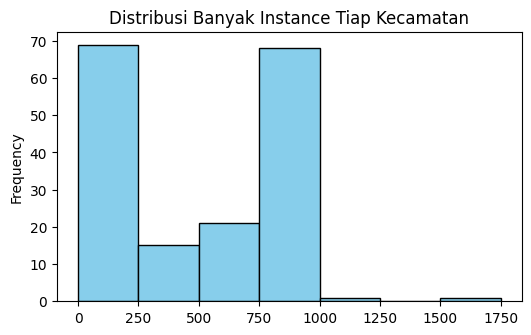

In [20]:
count_kecamatan = df['sub_district'].value_counts()

plt.figure(figsize=(6, 3.5))
plt.title('Distribusi Banyak Instance Tiap Kecamatan')
plt.xlabel('Jumlah Kecamatan')
# show numbers over the bar
count_kecamatan.plot(kind='hist', bins=np.arange(0, 2000, 250), color='skyblue', edgecolor='black')

## Analysis

### Derived Price/Lt and Price/Lb

In [21]:
df['price_per_lt'] = df['price'] / df['lt']
df['price_per_lb'] = df['price'] / df['lb']

In [22]:
df = df[['location', 'sub_district', 'title', 'price', 'price_wording', 'lt', 'price_per_lt', 'lb', 'price_per_lb']]
df.sample(5, random_state=16)

,location,sub_district,title,price,price_wording,lt,price_per_lt,lb,price_per_lb
21601,Jakarta Selatan,Kebayoran Lama,Rumah HOOK LT 1042m² sukabumi selatan kbn jeruk,"7,350,000,000.0","Rp 7,35 Miliar","1,042.0","7,053,742.802303263",500.0,"14,700,000.0"
8416,Jakarta Utara,Pademangan,Rumah Pademangan Timur,"3,500,000,000.0","Rp 3,5 Miliar",140.0,"25,000,000.0",490.0,"7,142,857.142857143"
46068,Bogor,Parung Panjang,"Dijual rumah murah dan keren elsa tanpa DP, fr...","466,000,000.0",Rp 466 Juta,60.0,"7,766,666.666666667",30.0,"15,533,333.333333334"
56513,Depok,Sawangan,2 rumah mewah 2 lantai murah banting harga. De...,"2,850,000,000.0","Rp 2,85 Miliar",853.0,"3,341,148.8862837045",365.0,"7,808,219.178082191"
60583,Tangerang,Cipondoh,"Dijual Rumah 2 Lantai Cipondoh Cipondoh, Tangg...","1,100,000,000.0","Rp 1,1 Miliar",61.0,"18,032,786.8852459",110.0,"10,000,000.0"


### Extra Data Cleaning

#### Remove Rows that Price/LT and Price/LB > 250.000.000 (For comparisons Sudirman Area has NJOP about 100.000.000)

In [23]:
df = df[df['price_per_lt'] <= 250_000_000]

In [24]:
df = df[df['price_per_lt'] <= 250_000_000]

### Aggregate by Kecamatan

#### by Price

In [25]:
df_aggregate_price = df.groupby('sub_district').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price = df_aggregate_price.sort_values(by=('price', 'mean'), ascending=False)
df_aggregate_price

price                                         \
                                mean           median                   std   
sub_district                                                                  
Menteng         62,595,662,337.66234 50,000,000,000.0  59,346,253,668.75665   
Kebayoran Baru 32,193,832,271.762207 21,250,000,000.0  34,813,359,609.43671   
Setiabudi        16,224,004,920.0492 12,000,000,000.0 16,705,469,091.998573   
Tanah Abang     14,585,711,985.68873 12,000,000,000.0  16,517,016,642.16032   
Kebayoran Lama 13,933,661,830.357143  8,700,000,000.0 18,160,897,666.408424   
...                              ...              ...                   ...   
Jasinga                284,500,000.0    310,000,000.0   86,338,481.18500425   
Leuwisadeng     261,666,666.66666666    300,000,000.0  66,395,280.956806965   
Solear           229,714,285.7142857    185,000,000.0  123,225,514.69775839   
Cisoka           219,722,222.2222222    181,000,000.0  107,257,130.59508944   
Jayanti         182,555,555.55555555    178,000,000.0  10,393,641.218445908   

                                                      
                         min               max count  
sub_district                                          
Menteng        492,000,000.0 550,000,000,000.0   924  
Kebayoran Baru 170,000,000.0 296,000,000,000.0   942  
Setiabudi      265,000,000.0 140,000,000,000.0   813  
Tanah Abang    115,000,000.0 105,000,000,000.0   559  
Kebayoran Lama 200,000,000.0 250,000,000,000.0   896  
...                      ...               ...   ...  
Jasinga        168,000,000.0     350,000,000.0     4  
Leuwisadeng    185,000,000.0     300,000,000.0     3  
Solear         115,000,000.0     540,000,000.0    14  
Cisoka         125,000,000.0     671,000,000.0    36  
Jayanti        178,000,000.0     210,000,000.0     9  

[175 rows x 6 columns]

In [26]:
ordered_list_price = df_aggregate_price['price']['mean'].keys().tolist()
ordered_list_price[:5]

['Menteng', 'Kebayoran Baru', 'Setiabudi', 'Tanah Abang', 'Kebayoran Lama']

#### by Price / LT

In [27]:
df_aggregate_price_lt  = df.groupby('sub_district').agg({'price_per_lt': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lt = df_aggregate_price_lt.sort_values(by=('price_per_lt', 'mean'), ascending=False)
df_aggregate_price_lt

price_per_lt                                            \
                               mean               median                  std   
sub_district                                                                    
Menteng         77,999,093.56651449         75,000,000.0 32,136,734.684205122   
Kebayoran Baru 62,988,657.620528206  57,683,228.41726619 30,082,319.590659395   
Tanah Abang     57,169,691.32805772  44,797,687.86127168  39,110,222.91756771   
Setiabudi      41,636,071.131449305         40,000,000.0 20,331,255.378802307   
Gambir          39,854,802.30408101 31,922,680.018345818 23,803,101.099296458   
...                             ...                  ...                  ...   
Kronjo         2,466,029.1897332664 2,466,029.1897332664   640,559.7413869078   
Leuwisadeng      2,462,560.38647343          3,000,000.0  1,003,906.550625532   
Cigudeg         1,956,116.687578419  1,956,116.687578419 1,847,127.9336152228   
Tenjolaya      1,814,886.3589219556 1,663,606.8351927693  1,050,630.238541415   
Cidaun         1,621,621.6216216215 1,621,621.6216216215                  NaN   

                                                                
                                min                  max count  
sub_district                                                    
Menteng                 9,840,000.0 238,784,370.47756875   924  
Kebayoran Baru 2,258,064.5161290322        234,375,000.0   942  
Tanah Abang               552,000.0  176,470,588.2352941   559  
Setiabudi        914,340.7122232916  214,285,714.2857143   813  
Gambir          4,222,222.222222222 158,730,158.73015872   324  
...                             ...                  ...   ...  
Kronjo         2,013,085.0528434827   2,918,973.32662305     2  
Leuwisadeng    1,304,347.8260869565 3,083,333.3333333335     3  
Cigudeg                   650,000.0  3,262,233.375156838     2  
Tenjolaya        761,904.7619047619 3,711,790.3930131006     6  
Cidaun         1,621,621.6216216215 1,621,621.6216216215     1  

[175 rows x 6 columns]

In [28]:
ordered_list_price_lt = df_aggregate_price_lt['price_per_lt']['mean'].keys().tolist()
ordered_list_price_lt[:5]

['Menteng', 'Kebayoran Baru', 'Tanah Abang', 'Setiabudi', 'Gambir']

#### by Price / LB

In [29]:
df_aggregate_price_lb = df.groupby('sub_district').agg({'price_per_lb': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lb = df_aggregate_price_lb.sort_values(by=('price_per_lb', 'mean'), ascending=False)
df_aggregate_price_lb

price_per_lb                                            \
                               mean               median                  std   
sub_district                                                                    
Menteng          95,419,891.7017507  76,204,225.35211268  84,228,847.06430878   
Kebayoran Baru   67,579,316.1067238 55,634,920.634920634  50,794,195.40603553   
Setiabudi       43,878,285.14485748         37,500,000.0  34,236,081.67289217   
Tanah Abang     35,794,946.47199516  25,098,814.22924901 27,392,777.590620104   
Kebayoran Lama 33,618,565.869940296   25,025,050.1002004  32,644,891.15711953   
...                             ...                  ...                  ...   
Solear          5,140,740.740740741  5,236,111.111111112 1,558,095.2422760862   
Mande           5,006,630.379699304          4,500,000.0 2,217,605.1280174395   
Leuwisadeng     4,305,555.555555556          3,750,000.0 1,654,819.0009562762   
Kronjo                  3,500,000.0          3,500,000.0   909,137.2900969895   
Cibeber        2,568,627.4509803923 2,568,627.4509803923   804,160.6531141129   

                                                                
                                min                  max count  
sub_district                                                    
Menteng          7,809,523.80952381      1,250,000,000.0   924  
Kebayoran Baru  2,827,140.549273021        550,000,000.0   942  
Setiabudi        633,333.3333333334  466,666,666.6666667   813  
Tanah Abang    1,604,938.2716049382 259,259,259.25925925   559  
Kebayoran Lama          3,250,000.0        470,000,000.0   896  
...                             ...                  ...   ...  
Solear                  2,600,000.0          7,500,000.0    14  
Mande           1,652,892.561983471  8,166,666.666666667     9  
Leuwisadeng             3,000,000.0  6,166,666.666666667     3  
Kronjo         2,857,142.8571428573 4,142,857.1428571427     2  
Cibeber                 2,000,000.0  3,137,254.901960784     2  

[175 rows x 6 columns]

In [30]:
ordered_list_price_lb = df_aggregate_price_lb['price_per_lb']['mean'].keys().tolist()
ordered_list_price_lb[:5]

['Menteng', 'Kebayoran Baru', 'Setiabudi', 'Tanah Abang', 'Kebayoran Lama']

### Aggregate by Kota

#### by Price

In [31]:
df_aggregate_price_city = df.groupby('location').agg({'price': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_city = df_aggregate_price_city.sort_values(by=('price', 'mean'), ascending=False)
df_aggregate_price_city

price                                        \
                                   mean          median                   std   
location                                                                        
Jakarta Pusat     18,311,181,186.015068 6,800,000,000.0  34,526,750,207.01236   
Jakarta Selatan   12,362,280,310.593456 7,100,000,000.0 17,461,445,735.035976   
Kepulauan Seribu        6,500,000,000.0 6,500,000,000.0                   0.0   
Jakarta Barat      5,341,116,666.666667 3,500,000,000.0  6,407,151,039.942303   
Jakarta Utara      4,753,384,081.329036 2,750,000,000.0  6,582,723,063.939593   
Jakarta Timur      3,933,829,053.095951 2,600,000,000.0   4,608,972,542.39517   
Tangerang Selatan 2,294,773,688.7360277 1,570,000,000.0 2,513,587,582.2357407   
Tangerang         1,947,973,379.5493934 1,350,000,000.0 2,675,217,584.6706786   
Cianjur           1,918,219,047.6190476   899,000,000.0 2,917,941,294.8484173   
Depok              1,553,493,625.852357   900,000,000.0 2,407,622,653.5730886   
Bogor             1,514,286,486.4864864   775,000,000.0  2,594,039,812.403569   
Bekasi            1,257,154,268.4812868   800,000,000.0 1,781,697,179.4665477   

                                                            
                              min               max  count  
location                                                    
Jakarta Pusat       115,000,000.0 550,000,000,000.0   5177  
Jakarta Selatan     150,000,000.0 296,000,000,000.0   9015  
Kepulauan Seribu  6,500,000,000.0   6,500,000,000.0      2  
Jakarta Barat       110,000,000.0  85,000,000,000.0   5100  
Jakarta Utara       237,000,000.0  80,000,000,000.0   4033  
Jakarta Timur       100,000,000.0  90,000,000,000.0   6347  
Tangerang Selatan   111,000,000.0  39,900,000,000.0   5815  
Tangerang           100,000,000.0  60,200,000,000.0  14425  
Cianjur             125,000,000.0  25,000,000,000.0    735  
Depok               100,000,000.0  77,000,000,000.0  10119  
Bogor               100,000,000.0  49,900,000,000.0  12580  
Bekasi              100,000,000.0  45,000,000,000.0  12932

#

In [32]:
ordered_list_price_city = df_aggregate_price_city['price']['mean'].keys().tolist()
ordered_list_price_city[:5]

['Jakarta Pusat',
 'Jakarta Selatan',
 'Kepulauan Seribu',
 'Jakarta Barat',
 'Jakarta Utara']

#### by Price / LT

In [33]:
df_aggregate_price_lt_city  = df.groupby('location').agg({'price_per_lt': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lt_city = df_aggregate_price_lt_city.sort_values(by=('price_per_lt', 'mean'), ascending=False)
df_aggregate_price_lt_city

price_per_lt                       \
                                  mean               median   
location                                                      
Jakarta Pusat      39,737,143.14097058  29,411,764.70588235   
Jakarta Selatan   31,940,517.381345633 26,548,672.566371683   
Kepulauan Seribu          26,000,000.0         26,000,000.0   
Jakarta Utara     25,600,510.899362423 24,652,777.777777776   
Jakarta Barat      25,203,068.54865647 23,498,697.786236603   
Jakarta Timur     18,771,712.684313025  17,721,893.49112426   
Tangerang         14,937,061.647822933 12,727,272.727272727   
Tangerang Selatan 14,900,683.460660877         13,750,000.0   
Depok             11,503,125.258045083 10,666,666.666666666   
Bekasi             9,859,521.424840286          8,750,000.0   
Bogor             8,324,835.2506034365 7,440,864.7270918805   
Cianjur            4,519,286.599490409          3,500,000.0   

                                                             \
                                   std                  min   
location                                                      
Jakarta Pusat     29,770,119.841257762            552,000.0   
Jakarta Selatan   20,642,553.463217635   566,037.7358490566   
Kepulauan Seribu                   0.0         26,000,000.0   
Jakarta Utara      12,321,397.57279566 1,034,482.7586206896   
Jakarta Barat     11,643,433.742505139   694,444.4444444445   
Jakarta Timur      8,864,205.363791265  1,282,051.282051282   
Tangerang          9,319,063.922807656   578,034.6820809249   
Tangerang Selatan  6,665,874.421741404 1,541,666.6666666667   
Depok              6,066,154.261308018   932,504.4404973357   
Bekasi             5,239,311.614968724            200,000.0   
Bogor              4,852,960.757584278  387,755.10204081633   
Cianjur            4,623,244.855107672  228,494.62365591398   

                                               
                                   max  count  
location                                       
Jakarta Pusat     238,784,370.47756875   5177  
Jakarta Selatan    248,322,147.6510067   9015  
Kepulauan Seribu          26,000,000.0      2  
Jakarta Utara     195,652,173.91304347   4033  
Jakarta Barat     219,512,195.12195122   5100  
Jakarta Timur            236,000,000.0   6347  
Tangerang         227,272,727.27272728  14425  
Tangerang Selatan 113,114,754.09836066   5815  
Depok             157,894,736.84210527  10119  
Bekasi            220,930,232.55813953  12932  
Bogor             166,666,666.66666666  12580  
Cianjur            71,428,571.42857143    735

In [34]:
ordered_list_price_lt_city = df_aggregate_price_lt_city['price_per_lt']['mean'].keys().tolist()
ordered_list_price_lt_city[:5]

['Jakarta Pusat',
 'Jakarta Selatan',
 'Kepulauan Seribu',
 'Jakarta Utara',
 'Jakarta Barat']

#### by Price / LB

In [35]:
df_aggregate_price_lb_city  = df.groupby('location').agg({'price_per_lb': ['mean', 'median', 'std', 'min', 'max', 'count']})
df_aggregate_price_lb_city = df_aggregate_price_lb_city.sort_values(by=('price_per_lb', 'mean'), ascending=False)
df_aggregate_price_lb_city

price_per_lb                       \
                                  mean               median   
location                                                      
Jakarta Pusat      37,595,664.61582869  24,255,319.14893617   
Jakarta Selatan   32,244,477.377089184         24,000,000.0   
Jakarta Barat     19,775,771.127851743         16,875,000.0   
Jakarta Utara      18,669,129.48591787 16,600,265.604249667   
Jakarta Timur       17,889,701.7696423 15,333,333.333333334   
Kepulauan Seribu          16,250,000.0         16,250,000.0   
Tangerang Selatan 15,691,020.712509926 14,285,714.285714285   
Tangerang         14,696,291.513345622 13,380,281.690140845   
Depok              13,123,210.20746729 12,140,575.079872204   
Bogor              12,199,724.08570976 11,088,888.888888888   
Bekasi             11,609,337.89745926 10,818,181.818181818   
Cianjur            7,768,787.650288378  6,132,075.471698113   

                                                             \
                                   std                  min   
location                                                      
Jakarta Pusat     47,882,122.553194635          1,320,000.0   
Jakarta Selatan    29,411,010.77926888   633,333.3333333334   
Jakarta Barat     14,169,323.380729273   419,354.8387096774   
Jakarta Utara      10,610,488.14784571 1,046,153.8461538461   
Jakarta Timur     12,697,167.664716866  130,046.94835680751   
Kepulauan Seribu                   0.0         16,250,000.0   
Tangerang Selatan  7,751,868.793405241   814,132.1044546851   
Tangerang          7,741,533.455618741   383,047.2103004292   
Depok              7,967,806.761751164   942,028.9855072463   
Bogor              7,708,209.706496918  231,833.91003460207   
Bekasi             5,770,480.135090238   272,547.0763131814   
Cianjur            7,278,074.192909849  1,188,235.294117647   

                                               
                                   max  count  
location                                       
Jakarta Pusat          1,250,000,000.0   5177  
Jakarta Selatan          550,000,000.0   9015  
Jakarta Barat            425,000,000.0   5100  
Jakarta Utara            200,000,000.0   4033  
Jakarta Timur      324,074,074.0740741   6347  
Kepulauan Seribu          16,250,000.0      2  
Tangerang Selatan 166,666,666.66666666   5815  
Tangerang          178,260,869.5652174  14425  
Depok              336,363,636.3636364  10119  
Bogor                    250,000,000.0  12580  
Bekasi            133,333,333.33333333  12932  
Cianjur            80,399,999.99999999    735

In [36]:
ordered_list_price_lb_city = df_aggregate_price_lb_city['price_per_lb']['mean'].keys().tolist()
ordered_list_price_lb_city[:5]

['Jakarta Pusat',
 'Jakarta Selatan',
 'Jakarta Barat',
 'Jakarta Utara',
 'Jakarta Timur']

### Scatter Plot

#### Luas Tanah - Harga Rumah

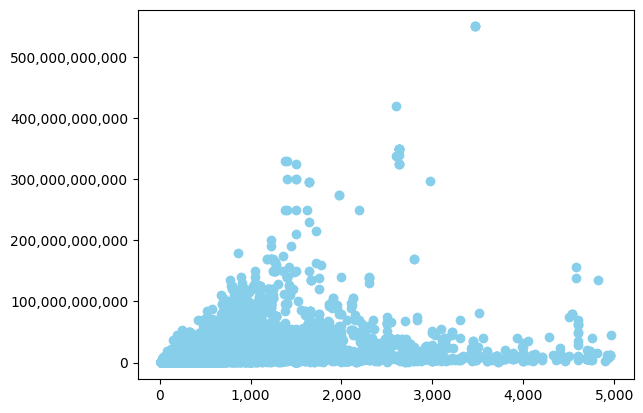

In [37]:
import matplotlib
fig, ax = plt.subplots()
ax.scatter(df['lt'], df['price'], color='skyblue')
ax.ticklabel_format(style='plain')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#### Luas Bangunan - Harga Rumah

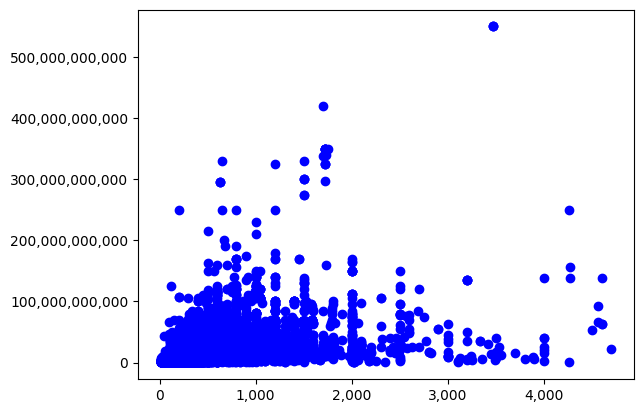

In [38]:
fig, ax = plt.subplots()
ax.scatter(df['lb'], df['price'], color='blue')
ax.ticklabel_format(style='plain')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))